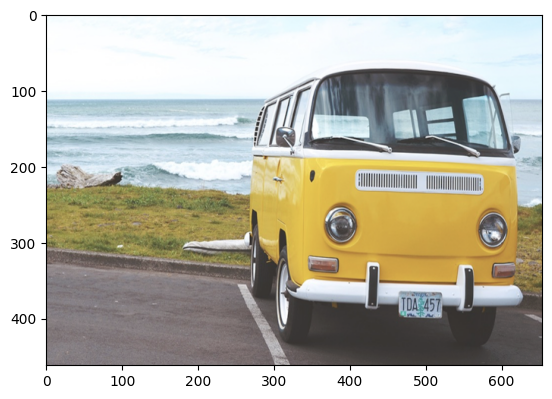

In [2]:
from skimage import segmentation, morphology
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import ndimage
from skimage.io import imread
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.color import label2rgb
from skimage.transform import resize

# Load the image
# image = imread('test.jpg')
image = imread('bus.png')

# show image
import matplotlib.pyplot as plt

plt.imshow(image)

Resizing image
512 725.0
SLIC number of segments: 27
SLIC segments shape: (512, 725)


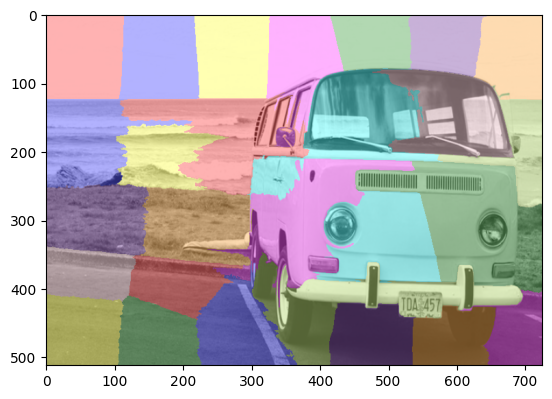

In [14]:
# let us first resize image to prevent memory issues
MAX_EDGE_LENGTH = 512
height = image.shape[0]
width = image.shape[1]
width_height_ratio = height / width

is_width_longer = width > height
should_resize = height > MAX_EDGE_LENGTH or width > MAX_EDGE_LENGTH

resized_image = None

resize_ratio = 1

newWidth = width
newHeight = height

if should_resize:
    print('Resizing image')
    if is_width_longer:
        newWidth = 512
        newHeight = 512 * width_height_ratio
    else:
        newHeight = 512
        newWidth = 512 / width_height_ratio


image = resize(image, (newHeight, newWidth))

print(newHeight, newWidth)

# if 4 channels, remove the alpha channel
if image.shape[2] == 4:
    image = image[:, :, :3]
# image = resize(image, (256, 256))

# Convert the image to Lab color space
lab_image = rgb2lab(image)

# Step 1: Apply SLIC algorithm to create superpixels
# n_segments: number of segments (= the desired number of superpixels) -> Superpixel: a group of connected pixels that share similar color
# More superpixels -> more segments -> more detailed segmentation
# compactness: balance between color proximity and space proximity
# sigma: width of Gaussian smoothing kernel
segments_slic = segmentation.slic(image, n_segments=30, compactness=20, sigma=0.5) # each pixel is assigned to the superpixel it belongs to (numbered from 1 to n_segments)

print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))

print('SLIC segments shape: {}'.format(segments_slic.shape))

plt.imshow(label2rgb(segments_slic, image))


In [7]:

from scipy import stats

dominant_colors = []

i = 0
for segment_label in np.unique(segments_slic):
    # Get the average color of the superpixel
    mask = segments_slic == segment_label
    
    segment_colors = lab_image[mask]
    
    # apply k-means clustering to find the dominant colors
    # kmeans = KMeans(n_clusters=1).fit(segment_colors)
    
    # mode function returns the most frequent color in the segment
    # It is the same with k-nearest neighbors with k=1
    # print(segment_colors.reshape(-1, 3).shape)
    mode_result = stats.mode(segment_colors.reshape(-1, 3), axis=0)
    dominant_color_lab = mode_result.mode  # Most frequent color in LAB space
    dominant_color_lab = dominant_color_lab.reshape(1, 1, 3)
    
    dominant_color_rgb = lab2rgb(dominant_color_lab)
    
    # dominant_color_rgb = label2rgb(np.array(segment_label), colors=[dominant_color_lab], bg_label=0, bg_color=(0, 0, 0))
    dominant_colors.append(dominant_color_rgb * 256)
    # dominant_colors.append(dominant_color_rgb[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[256. 256. 256.]]]
[[[256. 256. 256.]]]
[[[251.98431373 254.99607843 256.        ]]]
[[[251.98431373 254.99607843 256.        ]]]
[[[243.95294118 250.98039216 256.        ]]]
[[[252.27840695 252.27843868 252.27843095]]]
[[[230.90196078 247.96862745 253.99215686]]]
[[[61.23866545 77.26209716 82.64460369]]]
[[[56.21960784 57.22352941 59.23137255]]]
[[[207.50210463 224.05052942 238.09323591]]]
[[[251.98431373 254.99607843 256.        ]]]
[[[183.60196078 210.42745098 228.98823529]]]
[[[213.75170676 233.78610292 250.39139253]]]
[[[222.03717177 185.05815025  74.657367  ]]]
[[[206.80784314 164.64313725  69.27058824]]]
[[[39.93665597 80.05599067 70.4159324 ]]]
[[[18.50257329 72.23382519 73.29808061]]]
[[[210.82352941 169.6627451   71.27843137]]]
[[[85.3104278  77.07632341 72.23752874]]]
[[[56.21960784 53.20784314 52.20392157]]]
[[[128.34705882 119.15686275 121.16470588]]]
[[[119.9475305  110.65783694 110.51516911]]]
[[[130.34313725 121.14117647 123.48235294]]]
[[[80.31372549 75.29411765 75.2

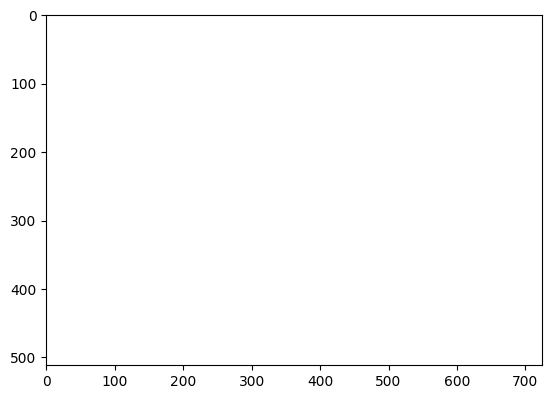

In [8]:

output_image = np.zeros_like(image)

for segment_label, color in zip(np.unique(segments_slic), dominant_colors):
    # print('segment_label: {}, color: {}'.format(segment_label, color))
    print(color)
    output_image[segments_slic == segment_label] = color

plt.imshow(output_image)

# print(output_image.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


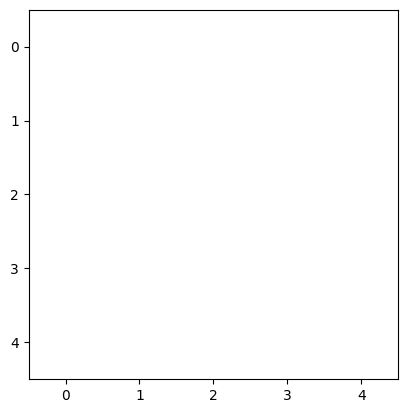

In [540]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.001
# we downsample the image by a factor of 2 (half the size)
# downsize to 5 X 5

downsampled = resize(output_image, (5,5), anti_aliasing=False)
upsampled = resize(downsampled, output_image.shape, anti_aliasing=False, order=0)

# Display the upsampled image or process it further as needed
plt.imshow(downsampled)



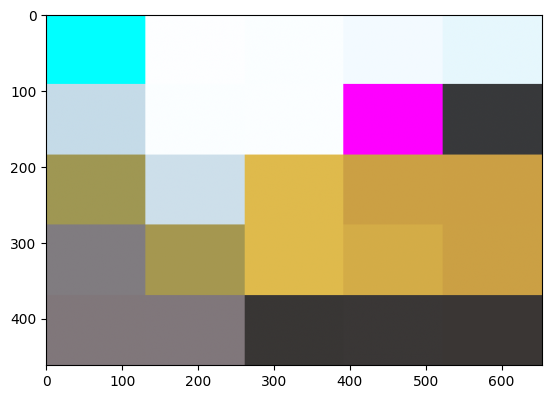

In [531]:
plt.imshow(upsampled)

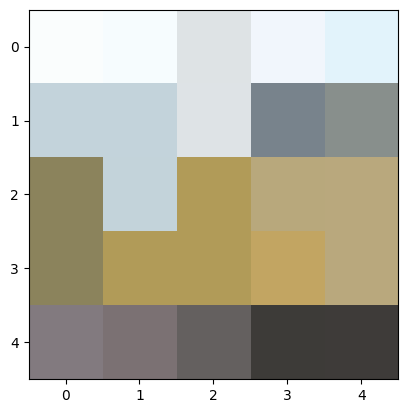

In [342]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.001
# we downsample the image by a factor of 2 (half the size)
# downsize to 5 X 5

downsampled = resize(out, (5,5), anti_aliasing=False)
# upsampled = resize(downsampled, out.shape, anti_aliasing=True)

# Display the upsampled image or process it further as needed
plt.imshow(downsampled)


In [145]:
print(upsampled.shape)

(3368, 2248, 3)


In [144]:
# To get square blocks, you can apply a dilation with a square structure element if needed
selem = morphology.square(5)  # Adjust the size of the square as needed
upsampled_blocks = morphology.dilation(upsampled, selem)

print(selem)
print('upsampled_blocks shape: {}'.format(upsampled_blocks.shape))

IndexError: tuple index out of range

In [120]:
# Step 4: Assign the superpixel the color
palette = lab2rgb(dominant_colors[:, np.newaxis, :])
output_image = np.zeros_like(image)

for segment_id, color in zip(segment_ids, palette):
    mask = segments_slic == segment_id
    output_image[mask] = (color * 255).astype(np.uint8)

print(output_image.shape)

(3368, 2248, 3)


In [121]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.1
# we downsample the image by a factor of 2 (half the size)
downsampled = resize(output_image, (int(output_image.shape[0] * scale_down_factor), int(output_image.shape[1] * scale_down_factor)), anti_aliasing=True)
upsampled = resize(downsampled, output_image.shape, anti_aliasing=True)

# Display the upsampled image or process it further as needed

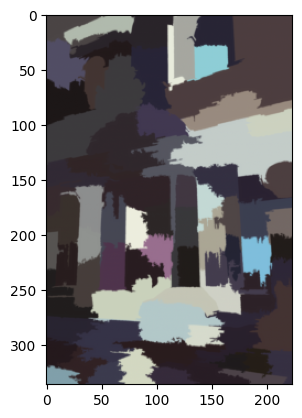

In [122]:
plt.imshow(downsampled)

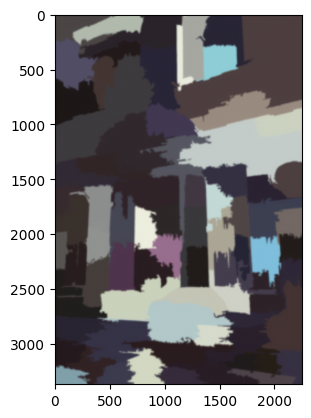

In [123]:
# plot upsamled image
plt.imshow(upsampled)